# __Step 3.1a: pubmed vocab to get tf and tf-idf__

&#128721;___This is a test file with notes. The production code is in 3.1b___

The goals for step 3 are to:
- Define the most prominent terms in plant biology overall
  - Based on Tf and Tf-idf
  - Based on science vocabs (oxford dictionary)
- Define the most prominent terms chrnologically
  - Monthly
  - Year
  - Decade with step size of 1??

3.1 specific goals:
- Get Tf matrix for the corpus (not used, see reason below)
- Get Tf-idf matrix using auto-generated vocabs
- Get Tf-idf matrix using dictionary vocabs
- Get Tf-idf matrix using combined vocabs
  - Use this for further analysis.

7/7/22 thoughts:
- Remove stop words, build vocab from corpus:
  - Get tf and tf-idf overall
    - Remove stop words
  - Get tf and tf-idf monthly
    - Remove stop words
- Remove stop words, build vocab use oxford dictionaries (3.2)
  - Get tf and tf-idf overall 
  - Get tf and tf-idf monthly
- This is the starting setting:
  - max_features = 10000
  - ngram_range  = (1,3)
  - max_df       = 0.8
  - min_df       = 0.01  # so at least ~4000 articles
  - stop_words   = list(stopwords.words('english'))
  - lowercase    = True
- After looking into Tf-based features:
  - There are simply too many non-scientific words. Not particularly helpful.
    - See if looking at only the top X helps - did not do this, just focus on tf-idf.
  - The total features returned with max_df=0.8 and min_df=0.01 may be a bit constranining, result in 2088 features only. 
    - Set min_df=0.001
    - Set max_features=2000
  - There are a number of features that are just numbers, some apparently are years.
    - Filter those out.
  - Some terms are synonyms.
    - May use semantic similarity to group them.
  - Given the above issues, Tf-idf is a better choice, particularly for dealing with the 1st problem. So focus on Tf-idf.

7/8/22 thoughts:
- Using the science dictionary as vocab lead to a gigantic sparse matrix where every word is counted. 
  - Need to filter the matrix so only columns with above threshold tf-idf will be used.
- The threshold tf-idf was going to be the min tf-idf of vectorizer with the following setting:
  - max_features = 2000
  - ngram_range  = (1,3)
  - max_df       = 0.8
  - min_df       = 0.001  # so at least ~400 articles
  - stop_words   = list(stopwords.words('english'))
  - lowercase    = True
  - The above lead to only 2000 features which may be too few. So:
    - Change max_features to 10000 again
    - ngram_range to (1,2)
  - Then examine the min tf-idf from this run.
  - Apply the min tf-idf sum as threshold for the dictionary-based run.
- Combine the autogenerated and dictionary-based vocabs
  - rid of those that are numeric
- Ok, just looked at the combo dictionary tf-idf, not good. There are too many words that just not scientific. So rethink my strategy:
  - Focus on dictionary words only
  - Get Tf and Tf-idf both going.
  - This is done in 3.1b

## ___Set up___

### Module import

In [5]:
import pickle
import pandas as pd
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from sklearn import feature_extraction

### Key variables

In [6]:
# Reproducibility
seed = 20220609

# Setting working directory
proj_dir   = Path.home() / "projects/plant_sci_hist"
work_dir   = proj_dir / "3_key_term_temporal/3_1_pubmed_vocab"
work_dir.mkdir(parents=True, exist_ok=True)

os.chdir(work_dir)

# science dictionary vocab directory
sci_dict_dir = proj_dir / "_vocab"

# specify plant science corpus
corpus_dir  = proj_dir / "2_text_classify/2_5_predict_pubmed"
corpus_file = corpus_dir / "corpus_plant_421658.tsv.gz"

# vecotrizer parameters
max_features = 10000
ngram_range  = (1,2)
max_df       = 0.8
min_df       = 0.001  # so at least ~400 articles
stop_words   = list(stopwords.words('english'))
lowercase    = True

### Read corpus into dataframe

In [28]:
corpus_df = pd.read_csv(corpus_file, sep='\t', compression='gzip')
corpus_df.shape

(421658, 11)

In [29]:
corpus_df.head(2)

,Unnamed: 0,PMID,Date,Journal,Title,Abstract,QualifiedName,txt,reg_article,y_prob,y_pred
0,3,61,1975-12-11,Biochimica et biophysica acta,Identification of the 120 mus phase in the dec...,After a 500 mus laser flash a 120 mus phase in...,spinach,Identification of the 120 mus phase in the dec...,1,0.716394,1
1,4,67,1975-11-20,Biochimica et biophysica acta,Cholinesterases from plant tissues. VI. Prelim...,Enzymes capable of hydrolyzing esters of thioc...,plant,Cholinesterases from plant tissues. VI. Prelim...,1,0.894874,1


### Define X

In [30]:
# corpus
X = corpus_df['txt']

## ___Set up vectorizers using corpus vocab___

### Tf using corpus vocab

7/8/22: This was not run again after today.

In [ ]:
# term-frequency vectorizer
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
vec_TF = feature_extraction.text.CountVectorizer(max_features = max_features, 
                                                 ngram_range  = ngram_range,
                                                 stop_words   = stop_words,
                                                 max_df       = max_df,
                                                 min_df       = min_df,
                                                 lowercase    = lowercase)

In [ ]:
# term frequencies: 15 min
vec_TF.fit(X)

# Transform corpus: ~3 min
X_TF = vec_TF.transform(X)

# Get feature names
vocab_TF = vec_TF.vocabulary_
feat_TF  = vec_TF.get_feature_names_out()
type(vocab_TF), type(feat_TF)

# Convert to dataframe
X_TF_df  = pd.DataFrame(X_TF.toarray(), columns=feat_TF)

In [ ]:
# Get only numeric columns
feat_non_numeric = [feat for feat in feat_TF if not feat.isnumeric()]
X_TF_df = X_TF_df[feat_non_numeric]

In [ ]:
X_TF_df['PMID'] = corpus_df['PMID']

In [ ]:
X_TF_df.head(1)

In [ ]:
# These are saved with setting: max_feature=10000, min_df=0.01
with open(work_dir / 'corpus_txt_tf_sparse_matrix', 'wb') as f:
  pickle.dump(X_TF, f)
with open(work_dir / 'corpus_txt_tf_features', 'wb') as f:
  pickle.dump(feat_TF, f)

### Tf-idf using corpus vocab

In [6]:
# tf-idf vectorizer    
vec_TI = feature_extraction.text.TfidfVectorizer(max_features = max_features, 
                                                 ngram_range  = ngram_range,
                                                 stop_words   = stop_words,
                                                 max_df       = max_df,
                                                 min_df       = min_df,
                                                 lowercase    = lowercase)

In [7]:
# term frequencies: ~5-20 min
vec_TI.fit(X)

TfidfVectorizer(max_df=0.8, max_features=10000, min_df=0.001,
                ngram_range=(1, 2),
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])

In [8]:
# Transform corpus: ~1-3 min
X_TI = vec_TI.transform(X)

In [ ]:
# Get feature names
feat_TI  = vec_TI.get_feature_names_out()
len(feat_TI)

10000

In [ ]:
# Output sparse matrix and features
with open(work_dir / 'corpus_txt_tfidf_sparse_matrix', 'wb') as f:
  pickle.dump(X_TI, f)
with open(work_dir / 'corpus_txt_tfidf_features', 'wb') as f:
  pickle.dump(feat_TI, f)

In [2]:
def get_col_sums_and_means(X_transformed, vocab):
  '''Get sum of row values for each column
  Args:
    X_transformed (Sparse array): vectorizer transformed X (texts)
    vocab (str): for output file name, indicating how vocab was generated
  Output:
    figure: distribution of tf-idf values for each column 
  '''

  # Get column sum
  col_sums = X_transformed.sum(axis=0)

  # numbers of rows and columns
  (num_r, num_c) = X_transformed.shape

  # col_sums is an Numpy Matrix, tried many way to get a list out of it like
  # ravel(), flatten(), but they don't work. So do it the old way.
  col_sums_list = []
  for i in tqdm(range(num_c)):
    col_sums_list.append(col_sums[0,i])

  # Get means
  col_means_list = [c_sum/num_r for c_sum in col_sums_list]

  fig, axes = plt.subplots(1, 2, figsize=(8,4))
  sns.histplot(col_sums_list, bins=100, log_scale=(False, True), ax=axes[0])
  axes[0].set_title("Sums of row Tf-idfs for each column")
  sns.histplot(col_means_list, bins=100, log_scale=(False, True), ax=axes[1])
  axes[1].set_title("Means of row Tf-idfs for each column")
  plt.savefig(work_dir / f"figure3_1_vocab_{vocab}_tf-idf_dist.pdf")

  return col_sums_list, col_means_list

In [37]:
# load X_TI and feat_TI in case the session died
with open(work_dir / 'corpus_txt_tfidf_sparse_matrix_vocab_auto', 'rb') as f:
  X_TI_loaded = pickle.load(f)
with open(work_dir / 'corpus_txt_tfidf_features_vocab_auto', 'rb') as f:
  feat_TI_loaded = pickle.load(f)

100%|██████████| 10000/10000 [00:00<00:00, 1102864.51it/s]


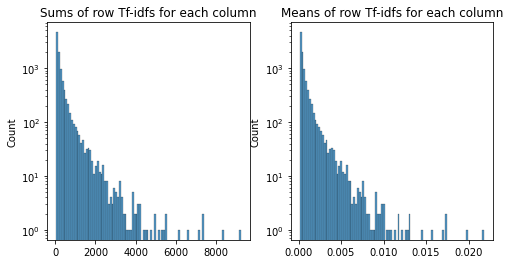

In [38]:
col_sums_list_TI, col_means_list_TI = get_col_sums_and_means(X_TI_loaded,"auto")

In [39]:
# minimum tf-idf value 
col_sums_list_TI_min  = min(col_sums_list_TI)
col_means_list_TI_min = min(col_means_list_TI)
col_sums_list_TI_min, col_means_list_TI_min

(58.44802562279117, 0.0001386147674721959)

In [40]:
col_sums_list_TI[:3], col_means_list_TI[:3]

([156.9406131510769, 689.493692373209, 163.13913194980174],
 [0.00037219882736975676, 0.0016351965155960732, 0.0003868991740932266])

## ___Set up vectorizers using science dict vocab___

### Get vocab list

In [42]:
# Get the dictionary file list
sci_dict_files = [i for i in sci_dict_dir.iterdir() \
                      if str(i).find(".items") != -1]
len(sci_dict_files)

11

In [64]:
# Go through files to generate a vocab dict and make sure it does not overlap
# with the autogenerated one earlier
# 7/8/22: Not used any more, realize that autogenerated vocab has too many words
# that are just common words.
'''
feat_TI_dict = dict(zip(feat_TI_loaded, [1]*len(feat_TI_loaded)))

sci_dict_vocab = {}
for file in sci_dict_files:
  print(str(file).split("/")[-1])
  with open(file, "r+") as f:
    items = f.readlines()
    for item in items:
      item_proc = item.lower().strip()
      # Does not overlap with the terms in auto generated vocabs
      if item_proc not in feat_TI_dict:
        sci_dict_vocab[item_proc] = 1
'''

'\nfeat_TI_dict = dict(zip(feat_TI_loaded, [1]*len(feat_TI_loaded)))\n\nsci_dict_vocab = {}\nfor file in sci_dict_files:\n  print(str(file).split("/")[-1])\n  with open(file, "r+") as f:\n    items = f.readlines()\n    for item in items:\n      item_proc = item.lower().strip()\n      # Does not overlap with the terms in auto generated vocabs\n      if item_proc not in feat_TI_dict:\n        sci_dict_vocab[item_proc] = 1\n'

In [44]:
sci_dict_vocab_list = list(sci_dict_vocab.keys())
len(sci_dict_vocab_list)

221056

### Set up vectorizer

In [26]:
# Note that here vocab is specified, max_features is ignored so not passed
vec_TI_sci_dict = feature_extraction.text.TfidfVectorizer(
                                          ngram_range  = ngram_range,
                                          stop_words   = stop_words,
                                          max_df       = max_df,
                                          min_df       = min_df,
                                          vocabulary   = sci_dict_vocab_list,
                                          lowercase    = lowercase)

In [31]:
# term frequencies: ~2 min! 
vec_TI_sci_dict.fit(X)

TfidfVectorizer(max_df=0.8, min_df=0.001, ngram_range=(1, 2),
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                vocabulary=['aav', 'a band', 'abc model', 'abdomen', 'abd...
                            'abo system', 'absolute refractory period',
                            'absorbed dose', 'absorption spectrum',
                            'abyssal zone', 'acarina', 'acceleration',
                            'accessory bud', 'accessory chromosome',
                            'accessory pigment', 'acclimatization',
                            'accommodation', 'acellular', 'acentric',
                            'acetabulum', 'acetylcholine',
                            'acetylcholinesterase', 'acetyl coenzyme a',
                            'achene', 'aciclovir', 'acid-base balance',
                            'alu element', ...])

In [32]:
# Transform corpus: 
X_TI_sci = vec_TI_sci_dict.transform(X)
X_TI_sci.shape, type(X_TI_sci)

((421658, 221056), scipy.sparse._csr.csr_matrix)

100%|██████████| 221056/221056 [00:00<00:00, 1165127.78it/s]


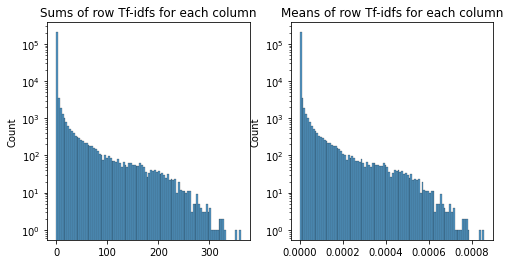

In [33]:
# Get feature names
feat_TI_sci  = vec_TI_sci_dict.get_feature_names_out()

# Get column sums
col_sums_list_TI_sci, _ = get_col_sums_and_means(X_TI_sci, "dict")

In [34]:
len(feat_TI_sci), len(col_sums_list_TI_sci)

(221056, 221056)

In [45]:
# Get feat_TI_sci entires that have above threshold mean tf-idf (0.001)
feat_TI_sci_qualified = []
for idx in tqdm(range(len(feat_TI_sci))):
  if col_sums_list_TI_sci[idx] >= col_sums_list_TI_min:
    feat_TI_sci_qualified.append(feat_TI_sci[idx])
len(feat_TI_sci_qualified)

100%|██████████| 221056/221056 [00:00<00:00, 3627704.87it/s]


3606

## ___Set up vectorizers using combined vocab___

### Combine auto-generated and filtered dictionary vocabs

In [46]:
type(feat_TI_loaded), type(feat_TI_sci_qualified)

(numpy.ndarray, list)

In [47]:
vocab_combo = list(feat_TI_loaded) + feat_TI_sci_qualified
len(vocab_combo)

13606

In [48]:
# Get only numeric columns
vocab_combo_nonnum = [feat for feat in vocab_combo if not feat.isnumeric()]
len(vocab_combo_nonnum)

13432

### Generate final tf-idf matrix

In [49]:
vec_TI_combo = feature_extraction.text.TfidfVectorizer(
                                          ngram_range  = ngram_range,
                                          stop_words   = stop_words,
                                          max_df       = max_df,
                                          min_df       = min_df,
                                          vocabulary   = vocab_combo_nonnum,
                                          lowercase    = lowercase)

# term frequencies
vec_TI_combo.fit(X)

# Transform corpus
X_TI_combo = vec_TI_combo.transform(X)

# Get feature names: should be the same as the vocab combo, but not sure about
# the order
feat_TI_combo = vec_TI_combo.get_feature_names_out()

### Save the matrix and feature

In [50]:
# Output sparse matrix and features
with open(work_dir / 'corpus_txt_tfidf_sparse_matrix_vocab_combo', 'wb') as f:
  pickle.dump(X_TI_combo, f)
with open(work_dir / 'corpus_txt_tfidf_features_vocab_combo', 'wb') as f:
  pickle.dump(feat_TI_combo, f)

In [51]:
X_TI_combo.shape, feat_TI_combo.shape

((421658, 13432), (13432,))

## ___Define overall key terms___

In [53]:
### Load tfidf matrix and feature names
with open(work_dir / 'corpus_txt_tfidf_sparse_matrix_vocab_combo', 'rb') as f:
  X_TI_combo_loaded = pickle.load(f)
with open(work_dir / 'corpus_txt_tfidf_features_vocab_combo', 'rb') as f:
  feat_TI_combo_loaded = pickle.load(f)
X_TI_combo_loaded.shape, feat_TI_combo_loaded.shape

((421658, 13432), (13432,))

100%|██████████| 13432/13432 [00:00<00:00, 1439651.73it/s]


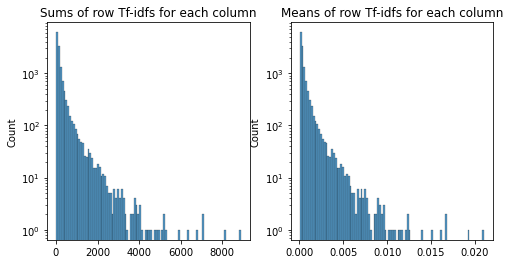

In [54]:
col_sums_list_TI_combo, _ = get_col_sums_and_means(X_TI_combo_loaded, "combo")

In [55]:
len(col_sums_list_TI_combo), len(feat_TI_combo_loaded)

(13432, 13432)

In [56]:
type(col_sums_list_TI_combo), type(feat_TI_combo_loaded)

(list, numpy.ndarray)

In [59]:
col_sum_df = pd.DataFrame(list(zip(feat_TI_combo_loaded.tolist(), 
                                   col_sums_list_TI_combo)),
                          columns=["Feature","Tf-idf sum"])

In [62]:
col_sum_df.shape, col_sum_df.head()

((13432, 2),
    Feature  Tf-idf sum
 0    10 10  153.211624
 1    10 15   96.019246
 2    10 20  117.640973
 3    10 cm   66.579266
 4  10 days  122.093169)

In [63]:
col_sum_df.to_csv(work_dir / "table3_1_vocab_combo_tfidf_sum.tsv", sep='\t')